In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, svm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Load data

In [2]:
df = pd.read_csv('data/cleanData.csv')
df['sentiment'] = np.where(df['Label']==1, 1, 0)
df

,Text,Label,sentiment
0,modi promise,-1,0
1,say vote modi welcome bjp told rahul main camp...,1,1
2,ask supporter prefix chowkidar name modi great...,1,1
3,answer among powerful world leader today trump...,1,1
4,upcoming election india saga go important pair...,1,1
...,...,...,...
34418,modi know sell institution like idbi bank form...,-1,0
34419,saw video full comedy show disclose plan test ...,-1,0
34420,dont waste think capacity observation people modi,-1,0
34421,open possibility shell company set sole purpos...,-1,0


# Train Test Split

In [3]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text'],df['sentiment'],test_size=0.2)
print('Size of Training data  : ', Train_X.shape[0])
print('Size of Validation data: ', Test_X.shape[0])

Size of Training data  :  27538
Size of Validation data:  6885


In [4]:
Train_counts = pd.DataFrame(Train_Y.values, columns = list('a'))
print('Train Data Distribution')
print(Train_counts['a'].value_counts())

Test_counts = pd.DataFrame(Test_Y.values, columns = list('a'))
print('\n\nValidation Data Distribution')
print(Test_counts['a'].value_counts())

Train Data Distribution
1    14311
0    13227
Name: a, dtype: int64


Validation Data Distribution
1    3632
0    3253
Name: a, dtype: int64


# Extracting Features
## TF-IDF
tf-idf (term frequency–inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

* Term Frequency tf, is the raw count of a term in a document.
* Inverse Document Frequency idf, is a measure of how much information the word provides, i.e., if it's common or rare across all documents.

## TfidfVectorizer
* **ngram_range=(min, max):** Boundary for different n-grams to be extracted. (1,1)=unigrams only, (1,2)=unigrams and bigrams, (2,2)=bigrams only.
* **max_df=<float in range[0.0, 1.0] or int default=1.0>:** Ignore terms with document frequency higher than max_df.
* **min_df=<float in range[0.0, 1.0] or int default=1.0>:** Ignore terms with document frequency lower than min_df.
* **max_features=int:** limits the features to be extracted to top max_features value
* **use_idf=bool(default=True):** Enable inverse-document-reweighting.
* **sublinear_tf=bool(default=False):** Apply sublinear tf scaling i.e. replace tf with 1+log(tf)

In [5]:
df_positive = df.loc[df["Label"]==1,:]
df_negative = df.loc[df["Label"]==-1,:]

Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=5)
#Learn the vocabulary
Tfidf_vect.fit(df['Text'].astype(str))
Train_X_Tfidf = Tfidf_vect.transform(Train_X.astype(str))
Test_X_Tfidf = Tfidf_vect.transform(Test_X.astype(str))

In [22]:
N = 20

#Positive data
features_positive = Tfidf_vect.fit_transform(df_positive.Text.astype(str))
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_positive.toarray()).flatten()[::-1]
top_positive = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
print('# Positive')
print(". {}".format('\n. '.join(top_positive)))

# Positive
. beating
. modi indian
. happen modi
. fast
. heart
. happen
. indian
. modi
. general public
. genius
. generation
. generate
. general secretary
. zone
. gentleman
. general election
. general
. gen
. gem
. gear


In [12]:
N = 20

#Negative data
features_negative = Tfidf_vect.fit_transform(df_negative.Text.astype(str))
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_negative.toarray()).flatten()[::-1]
top_negative = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
print('# Negative')
print(". {}".format('\n. '.join(top_negative)))

# Negative
. survive
. problem modi
. difficult
. actually
. problem
. without
. congress
. modi
. fully
. full majority
. full credit
. full
. fulfill promise
. fudge
. fulfill
. fuel
. fun
. fulfil
. fuel price
. fulfil promise


# Training Model

In [6]:
%%time
clf = svm.SVC()
clf = clf.fit(Train_X_Tfidf,Train_Y)

Wall time: 8min 8s


In [7]:
# predict the labels on validation dataset
predictions = clf.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("\nSVM Accuracy Score: {:.2f}%".format(accuracy_score(predictions, Test_Y)*100))
print("Confusion Matrix")
conf_mat = confusion_matrix(Test_Y,predictions)
print(conf_mat)


SVM Accuracy Score: 85.14%
Confusion Matrix
[[2692  561]
 [ 462 3170]]


Text(0.5, 24.0, 'Predicted')

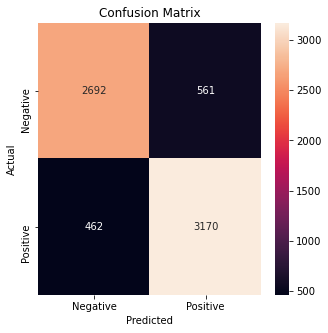

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')